#Random Forest

In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt


In [2]:
TRAIN_FEAT_PATH = "train_hh_features.csv"
TEST_FEAT_PATH  = "test_hh_features.csv"
TRAIN_GT_PATH   = "train_hh_gt.csv"
TRAIN_RATES_PATH = "train_rates_gt.csv"

train_feat = pd.read_csv(TRAIN_FEAT_PATH)
test_feat  = pd.read_csv(TEST_FEAT_PATH)
train_gt   = pd.read_csv(TRAIN_GT_PATH)
train_rates= pd.read_csv(TRAIN_RATES_PATH)

print(train_feat.shape, test_feat.shape, train_gt.shape, train_rates.shape)
train_feat.head()


(104234, 88) (103023, 88) (104234, 3) (3, 20)


,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,Yes,No,No,No,Yes,Yes,Yes,Yes,No,100000
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,Yes,No,No,No,No,Yes,Yes,No,No,100000
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,No,Yes,No,No,No,Yes,Yes,No,No,100000
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,Yes,No,No,Yes,No,Yes,Yes,Yes,No,100000


In [3]:

train = train_feat.merge(train_gt, on="hhid", how="inner", suffixes=("_feat",""))
train = train.drop(columns=["survey_id_feat"])

print(train.shape)
train[["survey_id","hhid","cons_ppp17","weight"]].head()


(104234, 89)


,survey_id,hhid,cons_ppp17,weight
0,100000,100001,25.258402,75
1,100000,100002,16.996706,150
2,100000,100003,13.671848,375
3,100000,100004,7.189475,375
4,100000,100005,12.308855,525


In [5]:
X_train = train.drop(columns=["cons_ppp17"])
y_train = np.log1p(train["cons_ppp17"].values)
sw_train = train["weight"].values

cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]), cat_cols)
])

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=25,
    max_features="sqrt",
    min_samples_leaf=2,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)

model = Pipeline([
    ("prep", preprocess),
    ("rf", rf)
])

model.fit(X_train, y_train, rf__sample_weight=sw_train)
print("Model trained")


Model trained


In [6]:

pred_train = np.expm1(model.predict(X_train))
true_train = train["cons_ppp17"].values

# Weighted MAPE
eps = 1e-9
wmape = (sw_train * np.abs(true_train - pred_train) / np.maximum(np.abs(true_train), eps)).sum() / sw_train.sum()
print("Train weighted MAPE:", wmape)


Train weighted MAPE: 0.15215661168785832


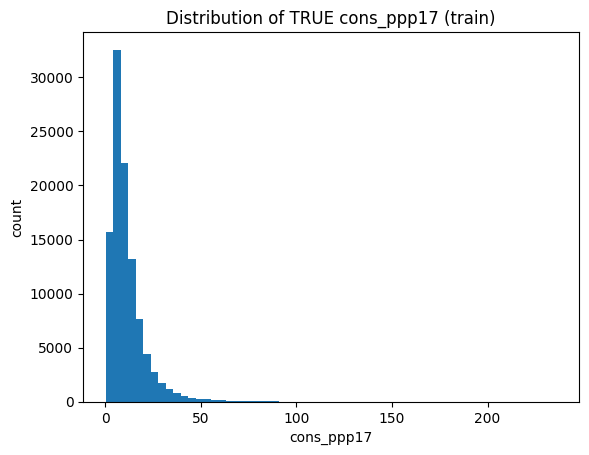

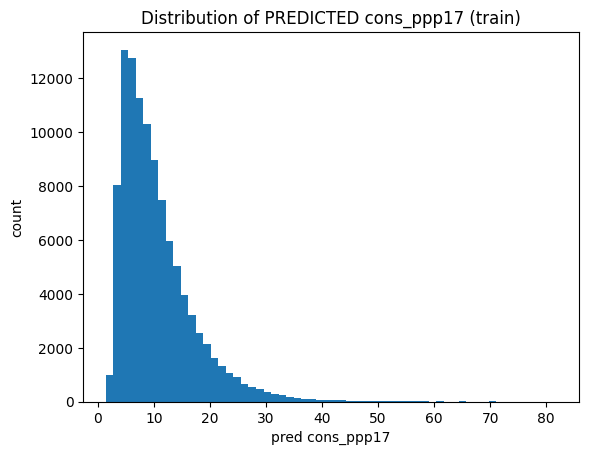

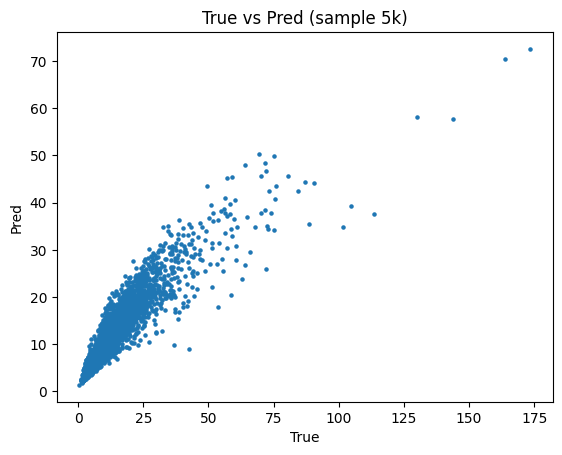

In [7]:
plt.figure()
plt.hist(true_train, bins=60)
plt.title("Distribution of TRUE cons_ppp17 (train)")
plt.xlabel("cons_ppp17")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(pred_train, bins=60)
plt.title("Distribution of PREDICTED cons_ppp17 (train)")
plt.xlabel("pred cons_ppp17")
plt.ylabel("count")
plt.show()

# scatter (sample για να μην βαραίνει)
sample_idx = np.random.RandomState(42).choice(len(true_train), size=5000, replace=False)
plt.figure()
plt.scatter(true_train[sample_idx], pred_train[sample_idx], s=5)
plt.title("True vs Pred (sample 5k)")
plt.xlabel("True")
plt.ylabel("Pred")
plt.show()


In [12]:
X_test = test_feat.copy()

pred_test_cons = np.expm1(model.predict(X_test))
pred_test_cons = np.clip(pred_test_cons, 0, None)

sub_cons = pd.DataFrame({
    "survey_id": X_test["survey_id"].astype(int),
    "hh_id": X_test["hhid"].astype(int),
    "cons_ppp17": pred_test_cons
}).sort_values(["survey_id", "hh_id"]).reset_index(drop=True)

sub_cons.head(), sub_cons.shape

(   survey_id   hh_id  cons_ppp17
 0     400000  400001   11.386471
 1     400000  400002    7.644839
 2     400000  400003    8.689595
 3     400000  400004   12.421470
 4     400000  400005    6.440720,
 (103023, 3))

In [13]:
# File 2: poverty distribution (weighted share strictly below thresholds)
threshold_cols = [c for c in train_rates.columns if c != "survey_id"]
thresholds = [float(c.split("_below_")[1]) for c in threshold_cols]

tmp = test_feat[["survey_id","hhid","weight"]].copy()
tmp["pred_cons"] = pred_test_cons

rows = []
for sid, g in tmp.groupby("survey_id"):
    w = g["weight"].values
    total = w.sum()
    row = {"survey_id": int(sid)}
    x = g["pred_cons"].values
    for col, thr in zip(threshold_cols, thresholds):
        row[col] = w[x < thr].sum() / total   # strictly below
    rows.append(row)

sub_pov = pd.DataFrame(rows).sort_values("survey_id").reset_index(drop=True)
sub_pov.head(), sub_pov.shape


(   survey_id  pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.60  \
 0     400000           0.006252           0.037374           0.079054   
 1     500000           0.004485           0.029748           0.070053   
 2     600000           0.005705           0.032451           0.069838   
 
    pct_hh_below_5.26  pct_hh_below_5.88  pct_hh_below_6.47  pct_hh_below_7.06  \
 0           0.127629           0.172081           0.212475           0.255275   
 1           0.115703           0.160499           0.202944           0.251809   
 2           0.113778           0.155439           0.196117           0.240432   
 
    pct_hh_below_7.70  pct_hh_below_8.40  pct_hh_below_9.13  pct_hh_below_9.87  \
 0           0.310067           0.372593           0.441716           0.513870   
 1           0.306926           0.373877           0.443521           0.515020   
 2           0.297872           0.362684           0.435029           0.510105   
 
    pct_hh_below_10.70  pct_hh_below_11.62

In [14]:
import zipfile, os

os.makedirs("submission", exist_ok=True)

cons_path = "submission/predicted_household_consumption.csv"
pov_path  = "submission/predicted_poverty_distribution.csv"
zip_path  = "submission/submission.zip"

sub_cons.to_csv(cons_path, index=False)
sub_pov.to_csv(pov_path, index=False)

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(cons_path, arcname="predicted_household_consumption.csv")
    z.write(pov_path, arcname="predicted_poverty_distribution.csv")

print("Wrote:", zip_path)


Wrote: submission/submission.zip


In [16]:
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np

groups = train["survey_id"].values

def weighted_mape(y_true, y_pred, sample_weight, eps=1e-9):
    return (
        sample_weight
        * np.abs(y_true - y_pred)
        / np.maximum(np.abs(y_true), eps)
    ).sum() / sample_weight.sum()

def neg_weighted_mape_log(y_true_log, y_pred_log, sample_weight):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return -weighted_mape(y_true, y_pred, sample_weight)

scorer = make_scorer(
    neg_weighted_mape_log,
    greater_is_better=True
)

param_dist = {
    "rf__n_estimators": [200, 400],
    "rf__max_depth": [20, 30],
    "rf__min_samples_leaf": [1, 2],
    "rf__min_samples_split": [2, 5],
    "rf__max_features": ["sqrt", 0.6]
}

cv = GroupKFold(n_splits=3)

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=cv.split(X_train, y_train, groups=groups),
    n_jobs=-1,
    random_state=42,
    verbose=2
)

search.fit(
    X_train,
    y_train,
    rf__sample_weight=sw_train
)

print("Best CV score (negative wMAPE):", search.best_score_)
print("Best parameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

best_model = search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best CV score (negative wMAPE): nan
Best parameters:
  rf__n_estimators: 400
  rf__min_samples_split: 2
  rf__min_samples_leaf: 2
  rf__max_features: 0.6
  rf__max_depth: 30


In [23]:
X_test = test_feat.copy()

pred_test_cons = np.expm1(best_model.predict(X_test))
pred_test_cons = np.clip(pred_test_cons, 0, None)

sub_cons = pd.DataFrame({
    "survey_id": X_test["survey_id"].astype(int),
    "hh_id": X_test["hhid"].astype(int),
    "cons_ppp17": pred_test_cons
}).sort_values(["survey_id", "hh_id"]).reset_index(drop=True)

sub_cons.head(), sub_cons.shape

(   survey_id   hh_id  cons_ppp17
 0     400000  400001   11.741067
 1     400000  400002    7.428965
 2     400000  400003    6.838975
 3     400000  400004   13.357891
 4     400000  400005    5.605946,
 (103023, 3))

In [24]:
# File 2: poverty distribution (weighted share strictly below thresholds)
threshold_cols = [c for c in train_rates.columns if c != "survey_id"]
thresholds = [float(c.split("_below_")[1]) for c in threshold_cols]

tmp = test_feat[["survey_id","hhid","weight"]].copy()
tmp["pred_cons"] = pred_test_cons

rows = []
for sid, g in tmp.groupby("survey_id"):
    w = g["weight"].values
    total = w.sum()
    row = {"survey_id": int(sid)}
    x = g["pred_cons"].values
    for col, thr in zip(threshold_cols, thresholds):
        row[col] = w[x < thr].sum() / total   # strictly below
    rows.append(row)

sub_pov = pd.DataFrame(rows).sort_values("survey_id").reset_index(drop=True)
sub_pov.head(), sub_pov.shape


(   survey_id  pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.60  \
 0     400000           0.009291           0.045007           0.089867   
 1     500000           0.006957           0.038466           0.079353   
 2     600000           0.008823           0.041025           0.079018   
 
    pct_hh_below_5.26  pct_hh_below_5.88  pct_hh_below_6.47  pct_hh_below_7.06  \
 0           0.141993           0.187887           0.234772           0.282941   
 1           0.127386           0.175611           0.222248           0.271108   
 2           0.123748           0.167914           0.211379           0.255871   
 
    pct_hh_below_7.70  pct_hh_below_8.40  pct_hh_below_9.13  pct_hh_below_9.87  \
 0           0.336543           0.399321           0.465592           0.527864   
 1           0.324924           0.388111           0.455019           0.518542   
 2           0.310937           0.379319           0.448794           0.513107   
 
    pct_hh_below_10.70  pct_hh_below_11.62

In [25]:
import zipfile, os

os.makedirs("submission1", exist_ok=True)

cons_path = "submission1/predicted_household_consumption.csv"
pov_path  = "submission1/predicted_poverty_distribution.csv"
zip_path  = "submission1/submission1.zip"

sub_cons.to_csv(cons_path, index=False)
sub_pov.to_csv(pov_path, index=False)

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(cons_path, arcname="predicted_household_consumption.csv")
    z.write(pov_path, arcname="predicted_poverty_distribution.csv")

print("Wrote:", zip_path)


Wrote: submission1/submission1.zip
